In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [94]:
import pandas as pd
import itertools
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix, classification_report, log_loss

In [104]:
n_splits = 8
animals = pd.read_csv('animals.csv')
animals.drop("ImputatedSex", inplace=True, axis=1)
animals = animals.rename(columns = {'Unnamed: 0':'ID'})
[(i, x) for i, x in enumerate(animals.columns)]

[(0, 'ID'),
 (1, 'AnimalID'),
 (2, 'Name'),
 (3, 'DateTime'),
 (4, 'OutcomeType'),
 (5, 'OutcomeSubtype'),
 (6, 'AnimalType'),
 (7, 'SexuponOutcome'),
 (8, 'AgeuponOutcome'),
 (9, 'Breed'),
 (10, 'Color'),
 (11, 'HasName'),
 (12, 'AgeinDays'),
 (13, 'Hour'),
 (14, 'Weekday'),
 (15, 'Month'),
 (16, 'WeekofYear'),
 (17, 'isHoliday'),
 (18, 'type'),
 (19, 'TransformedSex'),
 (20, 'Protects Property'),
 (21, 'Hunts & Chases'),
 (22, 'Less Likely to Wander'),
 (23, 'Loving'),
 (24, 'Child-Friendly'),
 (25, 'Dog-Friendly'),
 (26, 'Pet-Friendly'),
 (27, 'Stranger-Friendly'),
 (28, 'Avg Height (inches)'),
 (29, 'Avg Weight (pounds)'),
 (30, 'Size Score (1 to 5)'),
 (31, 'Avg Age'),
 (32, 'Fewer Health Issues'),
 (33, 'Energetic'),
 (34, 'Intelligent'),
 (35, 'Easy to Train'),
 (36, 'IsMix'),
 (37, 'Hair'),
 (38, 'IsMultiColor')]

In [105]:
animals.Hair = pd.Categorical(animals.Hair).codes # NaN becomes -1
animals.loc[animals.Hair == -1, 'Hair'] = np.nan
cols = [0] + range(11,39)
cats = animals[animals.AnimalType=='Cat'].iloc[:,cols]
dogs = animals[animals.AnimalType=='Dog'].iloc[:,cols]

Fix the NaN values for cats and dogs seperately because we have some different columns for each and don't want to impute values using the median from the other animal type.

In [106]:
pd.isnull(cats).sum() > 0

ID                       False
HasName                  False
AgeinDays                 True
Hour                     False
Weekday                  False
Month                    False
WeekofYear               False
isHoliday                False
type                     False
TransformedSex           False
Protects Property         True
Hunts & Chases            True
Less Likely to Wander     True
Loving                    True
Child-Friendly            True
Dog-Friendly              True
Pet-Friendly              True
Stranger-Friendly         True
Avg Height (inches)       True
Avg Weight (pounds)       True
Size Score (1 to 5)       True
Avg Age                   True
Fewer Health Issues       True
Energetic                 True
Intelligent               True
Easy to Train             True
IsMix                    False
Hair                      True
IsMultiColor             False
dtype: bool

In [107]:
imputer = Imputer(strategy='median')   
cats.iloc[:, 10:26] = -1
dogs.Hair = -1

In [108]:
dogs = pd.merge(dogs, pd.DataFrame(imputer.fit_transform(dogs), columns = animals.iloc[:, cols].columns), 
                how='inner', on='ID').iloc[:, [0] + range(29, 57)] 

cats = pd.merge(cats, pd.DataFrame(imputer.fit_transform(cats), columns = animals.iloc[:, cols].columns), 
                how='inner', on='ID').iloc[:, [0] + range(29, 57)]

outcomes = pd.DataFrame(animals.iloc[:, [0, 4]])
animals = pd.concat([dogs, cats])
animals = pd.merge(animals, outcomes, on='ID')
animals.columns = [x.replace('_y', '') for x in animals.columns]
pd.isnull(animals).sum() > 0

ID                       False
HasName                  False
AgeinDays                False
Hour                     False
Weekday                  False
Month                    False
WeekofYear               False
isHoliday                False
type                     False
TransformedSex           False
Protects Property        False
Hunts & Chases           False
Less Likely to Wander    False
Loving                   False
Child-Friendly           False
Dog-Friendly             False
Pet-Friendly             False
Stranger-Friendly        False
Avg Height (inches)      False
Avg Weight (pounds)      False
Size Score (1 to 5)      False
Avg Age                  False
Fewer Health Issues      False
Energetic                False
Intelligent              False
Easy to Train            False
IsMix                    False
Hair                     False
IsMultiColor             False
OutcomeType              False
dtype: bool

In [109]:
def run_skf(data, n_splits=10):
    skf = StratifiedKFold(n_splits, random_state=8, shuffle=True)
    t = data.OutcomeType
    train, test = [], []
    for train_index, validate_index in skf.split(np.zeros(len(t)), t):
        train.append(data.loc[train_index])
        test.append(data.loc[validate_index])
    return train, test

In [113]:
def visualize_folds(data, train, test):
    print('Total number of samples:{}\n'.format(len(data)))
    print('Training sample size per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .ID.rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(train)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    print('Test samples per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .ID.rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(test)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

In [114]:
from plotnine import *

In [115]:
train, test = run_skf(animals, n_splits=n_splits)
visualize_folds(animals, train, test)

Total number of samples:26729

Training sample size per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,9422,172,1360,4187,8244,23385
Fold 2,9423,172,1360,4187,8244,23386
Fold 3,9423,172,1360,4188,8244,23387
Fold 4,9423,172,1361,4188,8244,23388
Fold 5,9423,172,1361,4188,8244,23388
Fold 6,9423,173,1361,4188,8244,23389
Fold 7,9423,173,1361,4188,8245,23390
Fold 8,9423,173,1361,4188,8245,23390


Test samples per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,1347,25,195,599,1178,3344
Fold 2,1346,25,195,599,1178,3343
Fold 3,1346,25,195,598,1178,3342
Fold 4,1346,25,194,598,1178,3341
Fold 5,1346,25,194,598,1178,3341
Fold 6,1346,24,194,598,1178,3340
Fold 7,1346,24,194,598,1177,3339
Fold 8,1346,24,194,598,1177,3339


In [116]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)

In [117]:
def plot_results(log_loss_train, log_loss_test, test, train, pred_test, target_names, i):
    print('Train log loss:', log_loss_train)
    print('Test log loss:', log_loss_test)
    
    cm = confusion_matrix(test[i].OutcomeType.tolist(), pred_test, labels=target_names)
    plot_confusion_matrix(
        cm, target_names,
        title='Confusion Matrix for Fold {0} of {1}'.format(i+1, len(train)))
    print(classification_report(test[i].OutcomeType.tolist(), 
                            pred_test, target_names=target_names))

In [148]:
def run_forest_run(n_estimators, max_depth, avg_log_loss_train, avg_log_loss_test, 
                   test, train, target_names, i):    
    clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, random_state=8)  

    clf.fit(train[i].iloc[:,1:-1], train[i].OutcomeType)
    pred_train = clf.predict(train[i].iloc[:,1:-1])
    pred_test = clf.predict(test[i].iloc[:,1:-1])
    
    pred_train = pd.Categorical(pred_train, categories=target_names)
    pred_test = pd.Categorical(pred_test, categories=target_names)
    
    k1_train = pd.get_dummies(pred_train)
    k1_test = pd.get_dummies(pred_test)
    k1_train = k1_train.reindex_axis(sorted(k1_train.columns), axis=1)
    k1_test = k1_test.reindex_axis(sorted(k1_test.columns), axis=1)
    
    log_loss_train = log_loss(pd.get_dummies(train[i].OutcomeType), k1_train)
    log_loss_test = log_loss(pd.get_dummies(test[i].OutcomeType), k1_test)
       
    avg_log_loss_train += log_loss_train
    avg_log_loss_test += log_loss_test
    
    # Print the feature ranking
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")

    X = train[i].iloc[:,1:-1]
    for f in range(X.shape[1]):
        print("%d. feature %s (%f)" % (f, X.columns[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    return pred_train, pred_test, log_loss_train, log_loss_test, avg_log_loss_test, avg_log_loss_train

Feature ranking:
0. feature HasName (0.205602)
1. feature AgeinDays (0.185209)
2. feature Hour (0.124924)
3. feature Weekday (0.080756)
4. feature Month (0.076939)
5. feature WeekofYear (0.058329)
6. feature isHoliday (0.046518)
7. feature type (0.022104)
8. feature TransformedSex (0.016238)
9. feature Protects Property (0.014676)
10. feature Hunts & Chases (0.013458)
11. feature Less Likely to Wander (0.013217)
12. feature Loving (0.012171)
13. feature Child-Friendly (0.012136)
14. feature Dog-Friendly (0.010812)
15. feature Pet-Friendly (0.010700)
16. feature Stranger-Friendly (0.010626)
17. feature Avg Height (inches) (0.010600)
18. feature Avg Weight (pounds) (0.010477)
19. feature Size Score (1 to 5) (0.009686)
20. feature Avg Age (0.008802)
21. feature Fewer Health Issues (0.008690)
22. feature Energetic (0.008127)
23. feature Intelligent (0.007789)
24. feature Easy to Train (0.007702)
25. feature IsMix (0.007283)
26. feature Hair (0.006169)
27. feature IsMultiColor (0.000258)


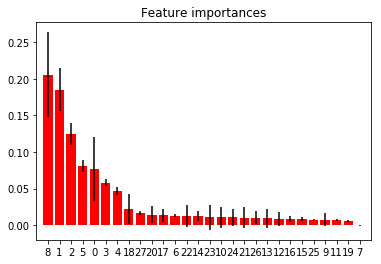

('Train log loss:', 5.011334971474537)
('Test log loss:', 10.576467412795621)
                 precision    recall  f1-score   support

       Adoption       0.71      0.84      0.77      1347
           Died       1.00      0.04      0.08        25
     Euthanasia       0.59      0.14      0.22       195
Return_to_owner       0.54      0.49      0.51       599
       Transfer       0.75      0.73      0.74      1178

    avg / total       0.69      0.69      0.68      3344

('Avg. train log loss:', 0.62641687143431712)
('Avg. test log loss:', 1.3220584265994526)


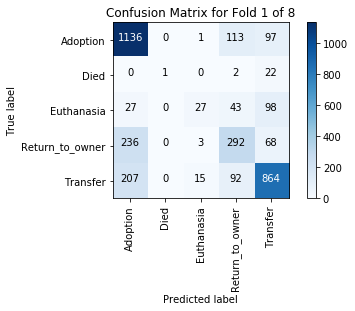

In [149]:
target_names = sort(animals.OutcomeType.unique())
avg_log_loss_train = 0
avg_log_loss_test = 0

for i in range(n_splits):
    (pred_train, pred_test, 
     log_loss_train, log_loss_test,
     avg_log_loss_test,
     avg_log_loss_train) = run_forest_run(25, 15, avg_log_loss_train, avg_log_loss_test, 
                                          test, train, target_names, i)    
    plot_results(log_loss_train, log_loss_test, test, train, pred_test, target_names, i)
    break

avg_log_loss_train /= n_splits
avg_log_loss_test /= n_splits
print('Avg. train log loss:', avg_log_loss_train)
print('Avg. test log loss:', avg_log_loss_test) 
    

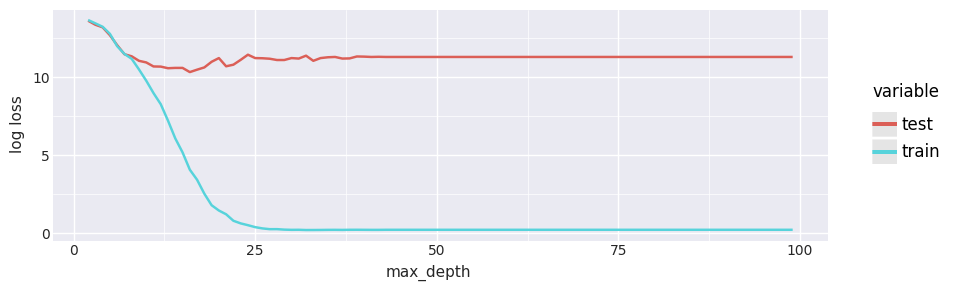

In [130]:
from multiprocessing import Pool

def iteration(i):
    try:
        (pred_train, pred_test, 
         log_loss_train, log_loss_test,
         _, _) = run_forest_run(20, i, avg_log_loss_train, avg_log_loss_test, 
                                test, train, target_names, 0) 
        return (i, log_loss_train, log_loss_test)
    except:
        import traceback
        traceback.print_exc()

range_ = range(2, 100)
p = Pool(processes=20)
result = p.map(iteration, range_)

ln_loss = pd.DataFrame(result, columns=['max_depth', 'train', 'test'])
ln_loss = pd.melt(ln_loss, id_vars=['max_depth'], value_vars=['train', 'test'])

(ggplot(ln_loss, aes(x='max_depth', y='value', color='variable'))
 + geom_line(size=1)
 + theme_seaborn()
 + theme(panel_grid_minor = element_line(size=0.5))
 + ylab('log loss')
).draw().set_size_inches(10, 3)

# TODO

* Try changing TransformedSex to not umpute Unknowns (and just just change the one NaN to an unknown). I think this will improve the results.